In [ ]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone https://$GITHUB_AUTH@github.com/JoseVillagranE/Tesis.git

GitHub user··········
GitHub password··········
Cloning into 'Tesis'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 348 (delta 223), reused 228 (delta 103), pack-reused 0
Receiving objects: 100% (348/348), 104.94 KiB | 14.99 MiB/s, done.
Resolving deltas: 100% (223/223), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ./Tesis/models/

/content/Tesis/models


In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from VAE import ConvVAE
import glob
from PIL import Image
from PIL import ImageFile
import os
matplotlib.style.use('ggplot')

In [4]:
class Carla_dataset(Dataset):
    
    def __init__(self, path, transforms=None, start_i=0, end_i=-1):
        
        self.path = path
        self.transforms = transforms
        self.start_i = start_i
        self.end_i = end_i
        
        self.data = self.read_data(path)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = image.split("/")[-1].split(".")[0]
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        image = Image.open(image).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image, label
    
    def read_data(self, path):
        images = glob.glob(os.path.join(path, "*.png"))
        if self.end_i == -1:
            images = images[self.start_i:]
        else:
            images = images[self.start_i:self.end_i]
        return images

In [2]:
n_channel = 3
z_dim = 128
batch_size = 256
lr = 1e-4
beta = 1
epochs = 300
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
trans = transforms.Compose([transforms.Resize((80, 160)), transforms.ToTensor()])
start_i = 0
end_i = 8000
train_set = Carla_dataset("../data", trans, end_i=end_i)
test_set = Carla_dataset("../data", trans, start_i=end_i)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [3]:
model = ConvVAE(n_channel, z_dim, beta)#.to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [4]:
model.load_state_dict(torch.load("./weights/segmodel_mse.pt"))

<All keys matched successfully>

In [ ]:
tr_loss, test_loss = [], []
min_test_loss = float("inf")
for epoch in range(epochs):
    model = model.train()
    mean_train_loss = 0
    for i, (X_tr, _) in enumerate(train_dataloader):
        X_tr = X_tr.to(device)
        recons, mu, logvar = model(X_tr)
        loss = model.compute_loss(X_tr, recons, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
        tr_loss.append(loss.item())
        mean_train_loss += loss.detach().item()
        
    if (epoch+1)%10==0:
        print(f"epoch: {epoch} || train_loss: {mean_train_loss/(i+1)}")
        model = model.eval()
        mean_test_loss = 0
        for j, (X_test, _) in enumerate(test_dataloader):
          X_test = X_test.to(device)
          recons, mu, logvar = model(X_test)
          loss = model.compute_loss(X_test, recons, mu, logvar)
          test_loss.append(loss.item())
          mean_test_loss += loss.item()

        current_test_loss = mean_test_loss/(j+1)
        if current_test_loss < min_test_loss:
          cnt = 0
          min_test_loss = current_test_loss
          torch.save(model.state_dict(), "./model.pt")
        else:
          cnt += 1
          if cnt >= 2:
            print("No Improvement")
            break

        print(f"epoch: {epoch} || test_loss: {current_test_loss}")

epoch: 9 || train_loss: 6214236.875
epoch: 9 || test_loss: 4485465.854166667
epoch: 19 || train_loss: 5891997.3125
epoch: 19 || test_loss: 4293533.6875
epoch: 29 || train_loss: 5772183.6875
epoch: 29 || test_loss: 4220350.166666667
epoch: 39 || train_loss: 5727803.8125
epoch: 39 || test_loss: 4195635.645833333
epoch: 49 || train_loss: 5700909.375
epoch: 49 || test_loss: 4180905.9166666665
epoch: 59 || train_loss: 5680943.0
epoch: 59 || test_loss: 4170224.75
epoch: 69 || train_loss: 5664896.375
epoch: 69 || test_loss: 4161519.5625
epoch: 79 || train_loss: 5651820.125
epoch: 79 || test_loss: 4154011.375
epoch: 89 || train_loss: 5641506.5625
epoch: 89 || test_loss: 4149788.8958333335
epoch: 99 || train_loss: 5632169.125
epoch: 99 || test_loss: 4145586.0
epoch: 109 || train_loss: 5624045.0
epoch: 109 || test_loss: 4142057.6041666665
epoch: 119 || train_loss: 5616643.875
epoch: 119 || test_loss: 4139758.2916666665
epoch: 129 || train_loss: 5609553.0
epoch: 129 || test_loss: 4137092.0
epoch:

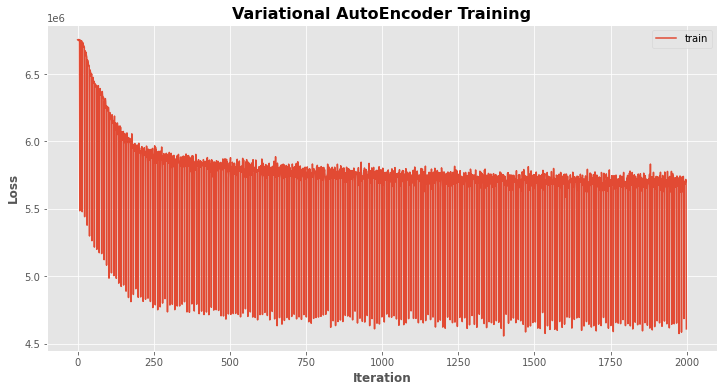

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(tr_loss, label='train')
plt.xlabel("Iteration", fontsize=12, fontweight='bold')
plt.ylabel("Loss", fontsize=12, fontweight='bold')
plt.title("Variational AutoEncoder Training", fontsize=16, fontweight='bold')
plt.legend(loc='best')

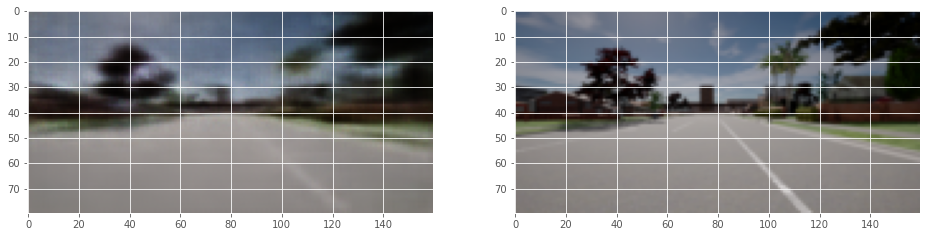

In [24]:
outp = model(test_set.__getitem__(-4)[0].unsqueeze(0))[0].squeeze()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
outp = np.moveaxis(outp.detach().numpy(), 0, -1)
im_0 = axes[0].imshow(outp)
test = np.moveaxis(test_set.__getitem__(-4)[0].numpy(), 0, -1)
im_1 = axes[1].imshow(test)

In [26]:
or_images = []
recons_images = [] 
for i in range(16):
    or_images.append(np.moveaxis(test_set.__getitem__(i)[0].unsqueeze(0).numpy().squeeze(), 0, -1))
    recons_images.append(np.moveaxis(model(test_set.__getitem__(i)[0].unsqueeze(0))[0].squeeze().detach().numpy(), 0, -1))

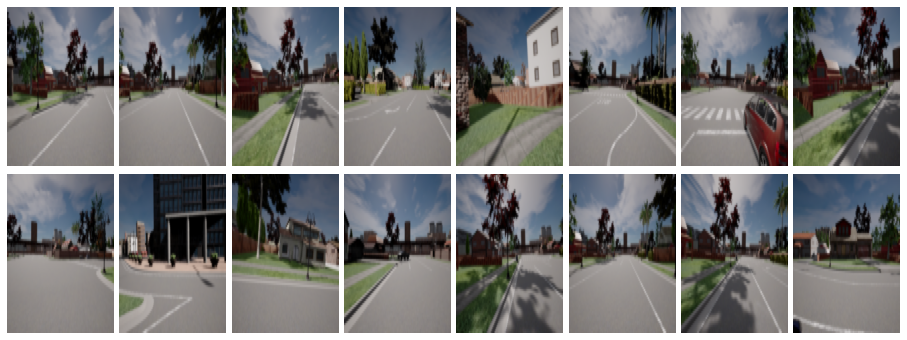

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16,6))
for idx, image in enumerate(or_images):
    row = idx // 8
    col = idx % 8
    axes[row, col].axis("off")
    axes[row, col].imshow(image, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

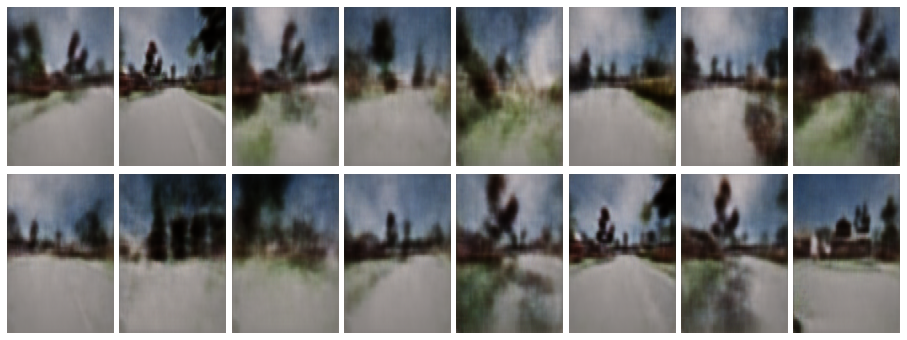

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16,6))
for idx, image in enumerate(recons_images):
    row = idx // 8
    col = idx % 8
    axes[row, col].axis("off")
    axes[row, col].imshow(image, aspect="auto")
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()



In [ ]:
torch.save(model.state_dict(), "model.pt")

In [29]:
model.save_struct("encoder", "encoder.pt")
model.save_struct("mu", "mu.pt")
model.save_struct("logvar", "logvar.pt")

In [27]:
image = Image.open("../Expert_samples_sem/482.png")
image = transforms.Resize((80, 160))(image)
tensor_image = transforms.ToTensor()(image)

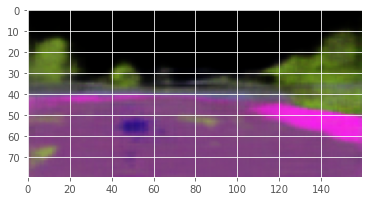

In [28]:
outp = model(tensor_image.unsqueeze(0))[0].squeeze()
plt.imshow(np.moveaxis(outp.detach().numpy(), 0, -1))

In [14]:
outp.shape

torch.Size([3, 80, 160])